In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torchvision.utils import make_grid,save_image


In [84]:
from datasets import load_dataset
ds = load_dataset("huggan/pokemon")

Repo card metadata block was not found. Setting CardData to empty.


In [87]:
!pip install wandb
# wandb login


In [97]:
transform = transforms.Compose([
    transforms.Resize(256),          # Resizes the shortest side to 64 pixels
    transforms.CenterCrop(256),      # Crops a 64x64 square from the center
    transforms.ToTensor(),          # Converts image (PIL or NumPy) to PyTorch Tensor (C x H x W), values in [0, 1]
    transforms.Normalize([0.5]*3, [0.5]*3)  # Scales pixel values from [0, 1] to [-1, 1] for each channel (R, G, B)
])


In [98]:
from torch.utils.data import Dataset
class POKEMON_DS(Dataset):
    def __init__(self,hf_dataset,transform = None):
        self.data = hf_dataset
        self.transform = transform
    def __len__(self):
        return self.data["train"].num_rows
    def __getitem__(self,idx):
        item = self.data["train"][idx]
        image = item["image"]
        if self.transform:
            img = self.transform(image)
        return img
        

In [99]:
from torch.utils.data import DataLoader

train_dataset = POKEMON_DS(ds, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)



In [100]:
z_dim = 100
batch_size = 64
lr = 2e-4
beta1 = 0.5
epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"
channels_img = 3
print(device)

cuda


In [101]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img):
        super().__init__()
        self.net = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, 1024, 4, 1, 0),    # N x 1024 x 4 x 4
            self._block(1024, 512, 4, 2, 1),      # N x 512 x 8 x 8
            self._block(512, 256, 4, 2, 1),       # N x 256 x 16 x 16
            self._block(256, 128, 4, 2, 1),       # N x 128 x 32 x 32
            self._block(128, 64, 4, 2, 1),        # N x 64 x 64 x 64
            self._block(64, 32, 4, 2, 1),         # N x 32 x 128 x 128
            nn.ConvTranspose2d(32, channels_img, 4, 2, 1),  # N x 3 x 256 x 256
            nn.Tanh(),  # Output in range [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.net(x)


In [102]:
class Discriminator(nn.Module):
    def __init__(self, channels_img):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, 32, 4, 2, 1),  # 256 → 128
            nn.LeakyReLU(0.2, inplace=True),
            self._block(32, 64, 4, 2, 1),   # 128 → 64
            self._block(64, 128, 4, 2, 1),  # 64 → 32
            self._block(128, 256, 4, 2, 1), # 32 → 16
            self._block(256, 512, 4, 2, 1), # 16 → 8
            self._block(512, 1024, 4, 2, 1),# 8 → 4
            nn.Conv2d(1024, 1, 4, 1, 0),    # 4 → 1
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.net(x)


In [103]:
gen = Generator(z_dim, channels_img).to(device)
disc = Discriminator(channels_img).to(device)

criterion = nn.BCELoss()
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)


In [108]:
import os
from tqdm import tqdm
from torchvision.utils import save_image
num_epochs = 100
# Create output directory once
os.makedirs("epoch_wise_image", exist_ok=True)

for epoch in range(num_epochs):
    gen.train()
    disc.train()

    if epoch < 10:
        gen_updates = 2
        disc_updates = 1
    else:
        gen_updates = 1
        disc_updates = 1

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, real in enumerate(loop):
        real = real.to(device)
        batch_size = real.size(0)

        # ---------------------
        # 1. Train Discriminator
        # ---------------------
        for _ in range(disc_updates):
            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = gen(z)

            disc_real = disc(real).view(-1)
            disc_fake = disc(fake.detach()).view(-1)

            lossD = -(torch.mean(torch.log(disc_real + 1e-8)) + torch.mean(torch.log(1 - disc_fake + 1e-8)))

            disc.zero_grad()
            lossD.backward()
            opt_disc.step()

        # ---------------------
        # 2. Train Generator
        # ---------------------
        for _ in range(gen_updates):
            z = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = gen(z)
            disc_fake = disc(fake).view(-1)

            lossG = -torch.mean(torch.log(disc_fake + 1e-8))

            gen.zero_grad()
            lossG.backward()
            opt_gen.step()

        loop.set_postfix({
            "Loss D": lossD.item(),
            "Loss G": lossG.item()
        })

    # ---------------------
    # Save generated images for this epoch
    # ---------------------
    with torch.no_grad():
        gen.eval()
        fixed_noise = torch.randn(16, z_dim, 1, 1).to(device)
        fake = gen(fixed_noise).detach().cpu()
        fake = (fake + 1) / 2  # unnormalize from [-1, 1] to [0, 1]
        save_image(fake, f"epoch_wise_image/epoch_{epoch+1:03d}.png", nrow=4)


Epoch 100/100: 100%|██████████| 115/115 [01:02<00:00,  1.85it/s, Loss D=0.0172, Loss G=6.29] 


In [109]:
import shutil

shutil.make_archive("generated_images", 'zip', "epoch_wise_image")


'/kaggle/working/generated_images.zip'

In [140]:
gen.eval()
z_dim = 100  
num_samples = 16
noise = torch.randn(num_samples, z_dim, 1, 1).to(device)
with torch.no_grad():
    fake_images = gen(noise).detach().cpu()
    fake_images = (fake_images + 1) / 2  # unnormalize 



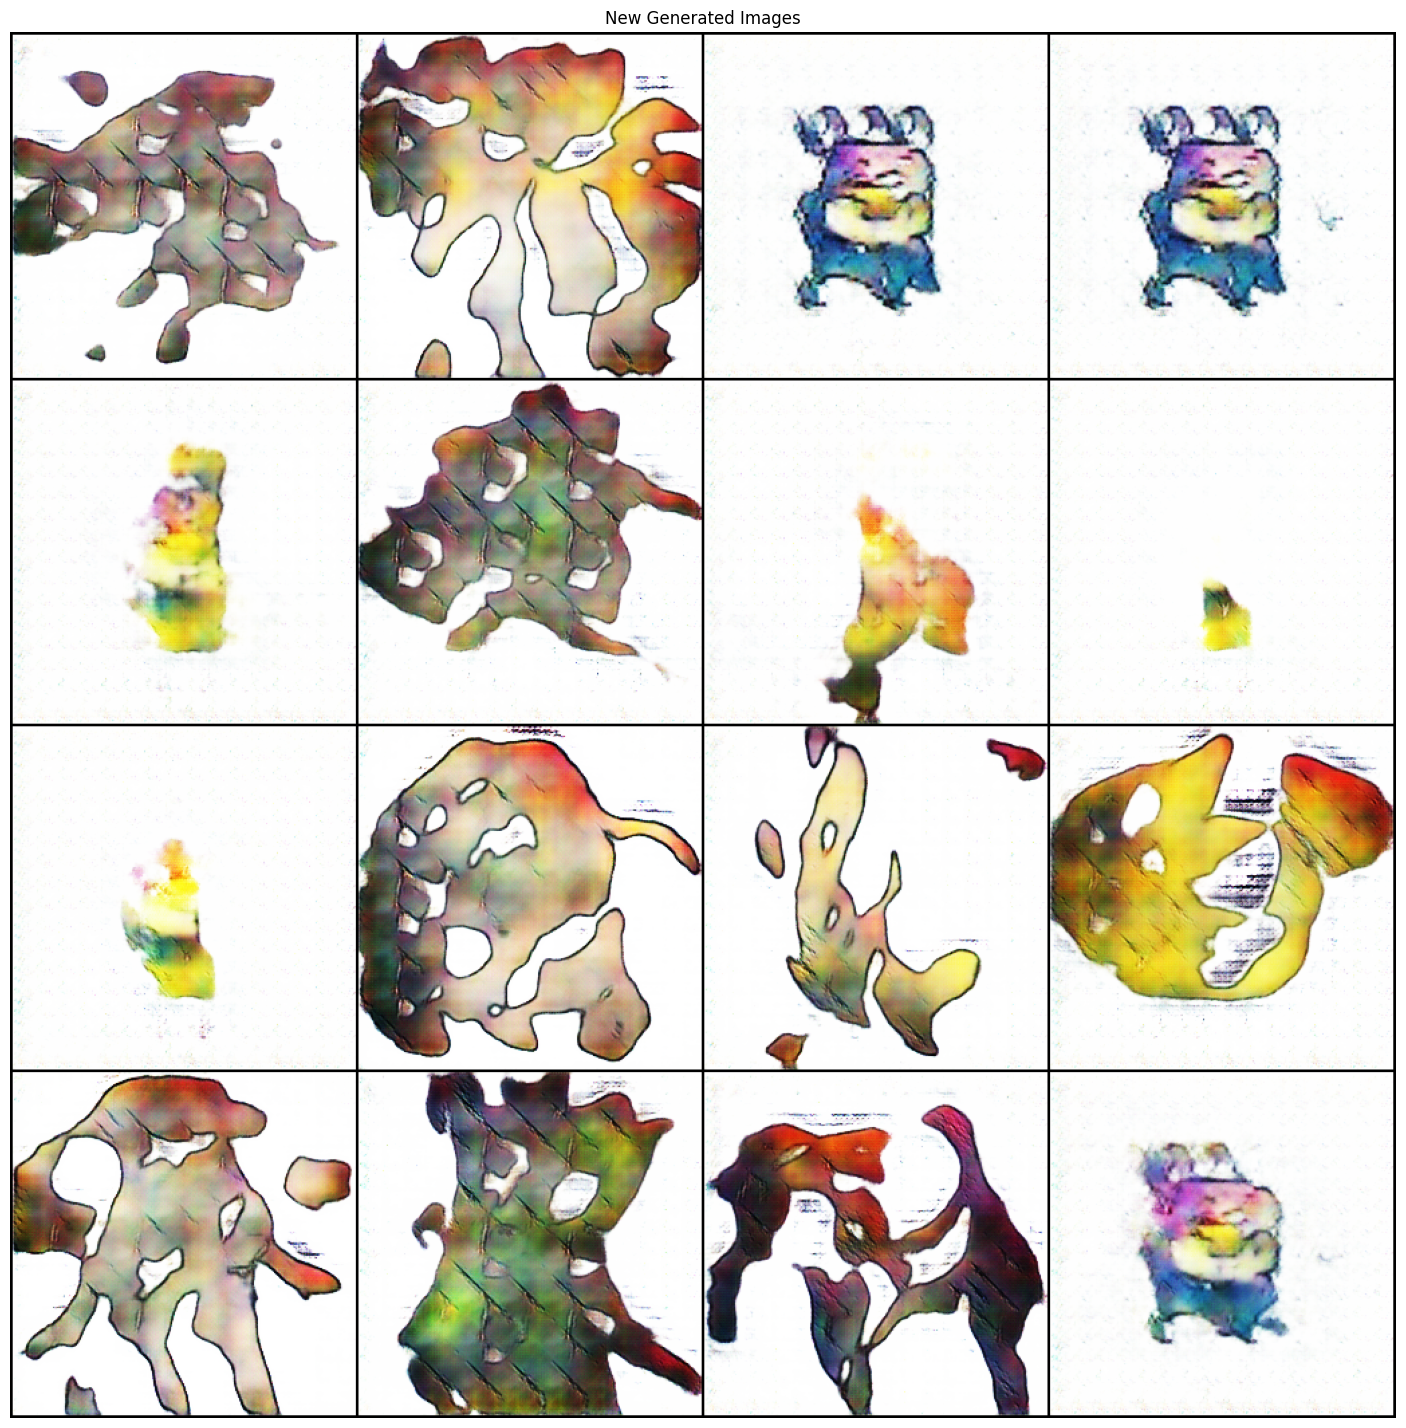

In [141]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

grid = make_grid(fake_images, nrow=4)

plt.figure(figsize=(18, 18))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("New Generated Images")
plt.show()
